In [72]:
import numpy as np
import data
import models
import cache
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
model_name = 'model6.2'
by = 'SubSet'
sample_n = 500 ## number genes
#test_sample_n = 1 ## number out of sample samples
#train_sample_n = None

In [9]:
sample_df = cache.cached(models.prep_sample_df,
                         sample_n=sample_n)

INFO:stancache.stancache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_500.pkl
INFO:stancache.stancache:prep_sample_df: Loading result from cache


In [10]:
sample_df.SubSet.unique()

array(['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1',
       'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory',
       'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17'], dtype=object)

In [11]:
# make training_df = sample_df, test_df = some synthetic mixtures
# first let's try making these mixtures manually

"""
notes from before about how we want to do this:
take raw lines, add them straight up with weights
naive B cells, memory B cells
(CD8, CD4)
Tregs vs naive B cells

first level of noise: gaussian noise on every transcript after the sum
so take mix1 + np.random.normal(0,1,len(mix1))
doesn't feel like enough noise tbh

second level of noise: vary the mixture weights for each transcript individually
weights_noisy = np.reshape(weights*len(mix1), reference[simple_cols].shape)
weights_noisy += np.abs(np.random.normal(0,0.1, weights_noisy.shape))
weights_noisy = weights_noisy.clip(0,1)
mix3=(weights_noisy * reference[simple_cols]).sum(axis=1)
mix3.head()

"""

training_df = sample_df

relevant_sample_ids = {
    'B_Naive': sample_df[sample_df['SubSet'] == 'B_Naive'].new_sample_id.unique(),
    'B_Memory': sample_df[sample_df['SubSet'] == 'B_Memory'].new_sample_id.unique(),
    'CD4_Treg': sample_df[sample_df['SubSet'] == 'CD4_Treg'].new_sample_id.unique(),
}
assert all([len(relevant_sample_ids[i]) > 0 for i in relevant_sample_ids])

bnaive_line = sample_df[sample_df['new_sample_id'] == relevant_sample_ids['B_Naive'][0]].copy()
bmemory_line = sample_df[sample_df['new_sample_id'] == relevant_sample_ids['B_Memory'][0]].copy()

weights = np.array([.25, .75])
weights = weights / np.sum(weights) # normalize
print('weights:', weights)
bnaive_line.loc[:,'est_counts'] *= weights[0]
bmemory_line.loc[:,'est_counts'] *= weights[1]
mixed_sample = pd.concat([bnaive_line, bmemory_line]).groupby(
    ['gene_name', 'new_gene_id'])['est_counts'].sum().reset_index()
mixed_sample.head(n=15)

weights: [ 0.25  0.75]


,gene_name,new_gene_id,est_counts
0,A4GALT,1,5.000000
1,AADACL3,2,0.250000
2,AAGAB,3,512.000473
3,ABCB10,4,200.097668
4,ABCC8,5,6.750000
5,AC000077.2,6,0.750000
6,AC004941.5,7,0.000000
7,AC007282.6,8,1.500000
8,AC009480.4,9,0.000000
9,AC010900.2,10,4.000000


In [12]:
# # sanity check
# a=sample_df[(sample_df['new_sample_id'] == relevant_sample_ids['B_Naive'][0]) & (sample_df['gene_name'] == 'AFTPH')]['est_counts'].values[0]
# b=sample_df[(sample_df['new_sample_id'] == relevant_sample_ids['B_Memory'][0]) & (sample_df['gene_name'] == 'AFTPH')]['est_counts'].values[0]
# computed=mixed_sample[mixed_sample['gene_name'] == 'AFTPH']['est_counts'].values[0]
# sanity_sum = weights[0] * a + weights[1] * b
# print('b naive value', a)
# print('b memory value', b)
# print('weights[0] * a + weights[1] * b = ', sanity_sum)
# print('computed:', computed)
# assert sanity_sum == computed, 'Issue with the weighted average'
# print('passed automatic sanity check')

In [13]:
# let's try running this thru stan now
# first, compress training_df -> small-training_df

# first, let's just sample a couple samples for now
#small_training_df=training_df.sample(n=10).copy() # this just loses genes, bad

all_train_samples = training_df.new_sample_id.unique()
print('number of training samples total:', len(all_train_samples))
print('total number of subsets in full training set:', len(training_df.SubSet.unique()))

#subset_of_samples = np.random.choice(all_train_samples, size=10)
#small_training_df = training_df[training_df['new_sample_id'].isin(subset_of_samples)]
#print('filtered to 10 samples that are from these subsets:', small_training_df.SubSet.unique())

# instead choose one sample from each subset
chosen_sample_ids = training_df.groupby('SubSet')['new_sample_id'].first().values
assert len(chosen_sample_ids) == len(training_df.SubSet.unique())
small_training_df = training_df[training_df['new_sample_id'].isin(chosen_sample_ids)].copy()
small_training_df

number of training samples total: 63
total number of subsets in full training set: 13


,index,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6+,CCR7+,...,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell,new_gene_cat,new_gene_id,new_sample_cat,new_sample_id
0,0,1,ERR431566,A4GALT,4.00000,1.371103,0.863355,1.609438,0.0,0.0,...,1.946368,1.302531,A4GALT,7,0,1,A4GALT,1,1,1
1,1,2,ERR431567,A4GALT,6.00000,0.910669,0.647453,1.945910,0.0,0.0,...,-0.185230,0.660665,A4GALT,7,0,1,A4GALT,1,2,2
2,2,3,ERR431568,A4GALT,8.00000,0.565729,0.448352,2.197225,0.0,0.0,...,-0.334004,0.068744,A4GALT,7,1,0,A4GALT,1,3,3
3,3,4,ERR431569,A4GALT,6.00000,0.686897,0.522891,1.945910,0.0,0.0,...,-0.784521,0.290346,A4GALT,7,1,0,A4GALT,1,4,4
4,4,5,ERR431570,A4GALT,2.00000,0.560374,0.444925,1.098612,0.0,0.0,...,0.039562,0.058558,A4GALT,7,0,1,A4GALT,1,5,5
5,5,6,ERR431571,A4GALT,0.00000,0.000000,0.000000,0.000000,0.0,1.0,...,-0.643897,-1.264184,A4GALT,7,0,1,A4GALT,1,6,6
6,6,7,ERR431572,A4GALT,2.00000,0.588103,0.462540,1.098612,0.0,0.0,...,0.032335,0.110926,A4GALT,7,1,0,A4GALT,1,7,7
9,9,10,ERR431575,A4GALT,4.00000,0.841286,0.610464,1.609438,0.0,0.0,...,0.885504,0.550697,A4GALT,7,0,1,A4GALT,1,10,10
12,12,13,ERR431578,A4GALT,1.00000,0.047160,0.046082,0.693147,0.0,1.0,...,-0.939999,-1.127184,A4GALT,7,0,1,A4GALT,1,13,13
16,16,17,ERR431582,A4GALT,2.00000,0.090574,0.086704,1.098612,0.0,1.0,...,-0.674359,-1.006416,A4GALT,7,0,1,A4GALT,1,17,17


In [14]:
small_training_df[by].head()

0         CD4_Th2
1    CD8_Effector
2           B_CD5
3        B_Memory
4         CD4_Th1
Name: SubSet, dtype: object

In [15]:
test_df = mixed_sample.copy()
test_df['sample_id'] = 10001
test_df['gene_id'] = test_df['new_gene_id']

#for dat in [small_training_df, test_df]:
for dat in [training_df, test_df]:
    dat.sort_values(['gene_id','sample_id'], inplace=True)
    dat['new_sample_cat'] = dat['sample_id'].astype('category')
    dat['new_sample_id'] = dat['new_sample_cat'].cat.codes+1

test_df

,gene_name,new_gene_id,est_counts,sample_id,gene_id,new_sample_cat,new_sample_id
0,A4GALT,1,5.000000,10001,1,10001,1
1,AADACL3,2,0.250000,10001,2,10001,1
2,AAGAB,3,512.000473,10001,3,10001,1
3,ABCB10,4,200.097668,10001,4,10001,1
4,ABCC8,5,6.750000,10001,5,10001,1
5,AC000077.2,6,0.750000,10001,6,10001,1
6,AC004941.5,7,0.000000,10001,7,10001,1
7,AC007282.6,8,1.500000,10001,8,10001,1
8,AC009480.4,9,0.000000,10001,9,10001,1
9,AC010900.2,10,4.000000,10001,10,10001,1


In [16]:
model_file = models.get_model_file(model_name=model_name)
#print(cache._read_file(model_file))

In [17]:
#stan_data = models.prep_stan_data(sample_df=small_training_df, test_df=None, by=by)
stan_data = models.prep_stan_data(sample_df=training_df, test_df=None, by=by)

stan_data

{'C': 13,
 'G': 500,
 'M': 20,
 'N': 31500,
 'S': 63,
 'cell_features':                      CCR6+  CCR7+  CCR7-  CD127-  CD161+  CD19+  CD25+  CD27+  \
 SubSet                                                                          
 CD4_Th2                0.0    0.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD8_Effector           0.0    0.0    1.0     0.0     0.0    0.0    0.0    0.0   
 B_CD5                  0.0    0.0    0.0     0.0     0.0    1.0    0.0    0.0   
 B_Memory               0.0    0.0    0.0     0.0     0.0    1.0    0.0    1.0   
 CD4_Th1                0.0    0.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD4_Naive              0.0    1.0    0.0     0.0     0.0    0.0    0.0    0.0   
 B_Naive                0.0    0.0    0.0     0.0     0.0    1.0    0.0    0.0   
 CD4_Effector_Memory    0.0    0.0    1.0     0.0     0.0    0.0    0.0    0.0   
 CD8_Central_Memory     0.0    1.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD4_Central_Memory     0.0

In [18]:
stan_data['x']

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
x2_data = pd.DataFrame(np.zeros((1, stan_data['x'].shape[1])), columns=stan_data['x'].columns)
x2_data['SubSet[B_Naive]'] = weights[0]
x2_data['SubSet[B_Memory]'] = weights[1]
x2_data

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#relevant_sample_ids

def get_sample_ids_by_subset(sample_df):
    return {subset: 
            sample_df[sample_df['SubSet'] == subset].new_sample_id.unique() for subset in sample_df.SubSet.unique()}
relevant_sample_ids = get_sample_ids_by_subset(sample_df)
relevant_sample_ids

{'B_CD5': array([ 3, 26, 31, 34]),
 'B_Memory': array([ 4, 29, 43, 48, 52]),
 'B_Naive': array([ 7, 21, 46, 54, 59]),
 'CD4_Central_Memory': array([17, 33, 49, 55, 61]),
 'CD4_Effector_Memory': array([10, 11, 23, 38, 51]),
 'CD4_Naive': array([ 6,  9, 15, 16, 45]),
 'CD4_Th1': array([ 5, 12, 19, 22, 57]),
 'CD4_Th17': array([30, 32, 39, 53, 60]),
 'CD4_Th2': array([ 1, 14, 35, 50, 63]),
 'CD4_Treg': array([18, 24, 36, 41, 44]),
 'CD8_Central_Memory': array([13, 28, 37, 42]),
 'CD8_Effector': array([ 2,  8, 20, 25, 56]),
 'CD8_Naive': array([27, 40, 47, 58, 62])}

In [21]:
# wrap above manual work into a function

def mix_cell_lines(xdata, subsets, weights, sample_ids=None, new_sample_id=10001):
    """
    e.g. xdata=stan_data['x'], subsets=['B_Naive', 'B_Memory'], weights=[.5, .5], sample_ids=None
    if sample_ids are None, the first sample of each subset is used
    """
    
    assert len(weights) == len(subsets)
    if not sample_ids:
        sample_ids = [relevant_sample_ids[subset][0] for subset in subsets]
    
    weights = np.array(weights)
    weights = weights / np.sum(weights) # normalize
    
    x2_data = pd.DataFrame(np.zeros((1, xdata.shape[1])), columns=xdata.columns)
    
    transformed_lines = []
    for subset, weight, sample_id in zip(subsets, weights, sample_ids):
        transformed = sample_df[sample_df['new_sample_id'] == sample_id].copy()
        transformed.loc[:,'est_counts'] *= weight
        transformed_lines.append(transformed)
        x2_data['SubSet[%s]' % subset] = weight
    
    mixed_sample = pd.concat(transformed_lines).groupby( \
        ['gene_name', 'new_gene_id'])['est_counts']\
        .sum().reset_index()
        
    mixed_sample['sample_id'] = new_sample_id
    
    return mixed_sample, x2_data
    
    
mix_cell_lines(xdata=stan_data['x'], subsets=['B_Naive', 'B_Memory'], weights=[.5, .5], sample_ids=None)

(            gene_name  new_gene_id   est_counts  sample_id
 0              A4GALT            1     4.000000      10001
 1             AADACL3            2     0.500000      10001
 2               AAGAB            3   480.000375      10001
 3              ABCB10            4   183.398445      10001
 4               ABCC8            5     5.500000      10001
 5          AC000077.2            6     0.500000      10001
 6          AC004941.5            7     0.000000      10001
 7          AC007282.6            8     1.000000      10001
 8          AC009480.4            9     0.000000      10001
 9          AC010900.2           10     3.000000      10001
 10         AC023274.4           11     0.000000      10001
 11         AC087651.2           12     0.000000      10001
 12         AC098824.6           13     1.500000      10001
 13         AC104389.2           14     0.000000      10001
 14         AC233755.2           15     4.553070      10001
 15         AC234301.1           16    1

In [22]:
relevant_sample_ids

{'B_CD5': array([ 3, 26, 31, 34]),
 'B_Memory': array([ 4, 29, 43, 48, 52]),
 'B_Naive': array([ 7, 21, 46, 54, 59]),
 'CD4_Central_Memory': array([17, 33, 49, 55, 61]),
 'CD4_Effector_Memory': array([10, 11, 23, 38, 51]),
 'CD4_Naive': array([ 6,  9, 15, 16, 45]),
 'CD4_Th1': array([ 5, 12, 19, 22, 57]),
 'CD4_Th17': array([30, 32, 39, 53, 60]),
 'CD4_Th2': array([ 1, 14, 35, 50, 63]),
 'CD4_Treg': array([18, 24, 36, 41, 44]),
 'CD8_Central_Memory': array([13, 28, 37, 42]),
 'CD8_Effector': array([ 2,  8, 20, 25, 56]),
 'CD8_Naive': array([27, 40, 47, 58, 62])}

In [23]:
# here are the mixtures we want
mix1, mix1_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.5, .5],
                              sample_ids=[7, 4],
                              new_sample_id = 10001)

mix2, mix2_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.5, .5],
                              sample_ids=[21, 29],
                              new_sample_id = 10002)

mix3, mix3_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.25, .75],
                              sample_ids=[7, 4],
                              new_sample_id = 10003)

mix4, mix4_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.25, .75],
                              sample_ids=[21, 29],
                              new_sample_id = 10004)

mix5, mix5_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.75, .25],
                              sample_ids=[7, 4],
                              new_sample_id = 10005)

mix6, mix6_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.75, .25],
                              sample_ids=[21, 29],
                              new_sample_id = 10006)

# tregs vs naive B cells

mix7, mix7_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.5, .5],
                              sample_ids=[7, 18],
                              new_sample_id = 10007)

mix8, mix8_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.25, .75],
                              sample_ids=[7, 18],
                              new_sample_id = 10008)

mix9, mix9_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.5, .5],
                              sample_ids=[21, 24],
                              new_sample_id = 10009)

mix10, mix10_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.25, .75],
                              sample_ids=[21, 24],
                              new_sample_id = 10010)


In [24]:
# make a test_df and x2_data with all of them
test_df = pd.concat([mix1, mix2, mix3, mix4, mix5, mix6, mix7, mix8, mix9, mix10])
test_df['gene_id'] = test_df['new_gene_id']
x2_data = pd.concat([mix1_x,mix2_x,mix3_x,mix4_x,mix5_x,mix6_x,mix7_x,mix8_x,mix9_x,mix10_x])

#for dat in [small_training_df, test_df]:
for dat in [training_df, test_df]:
    dat.sort_values(['gene_id','sample_id'], inplace=True)
    dat['new_sample_cat'] = dat['sample_id'].astype('category')
    dat['new_sample_id'] = dat['new_sample_cat'].cat.codes+1

In [25]:
test_df.head()

,gene_name,new_gene_id,est_counts,sample_id,gene_id,new_sample_cat,new_sample_id
0,A4GALT,1,4.00,10001,1,10001,1
0,A4GALT,1,2.50,10002,1,10002,2
0,A4GALT,1,5.00,10003,1,10003,3
0,A4GALT,1,3.25,10004,1,10004,4
0,A4GALT,1,3.00,10005,1,10005,5


In [26]:
x2_data.head()

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
training_df.head()

,index,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6+,CCR7+,...,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell,new_gene_cat,new_gene_id,new_sample_cat,new_sample_id
0,0,1,ERR431566,A4GALT,4.0,1.371103,0.863355,1.609438,0.0,0.0,...,1.946368,1.302531,A4GALT,7,0,1,A4GALT,1,1,1
1,1,2,ERR431567,A4GALT,6.0,0.910669,0.647453,1.945910,0.0,0.0,...,-0.185230,0.660665,A4GALT,7,0,1,A4GALT,1,2,2
2,2,3,ERR431568,A4GALT,8.0,0.565729,0.448352,2.197225,0.0,0.0,...,-0.334004,0.068744,A4GALT,7,1,0,A4GALT,1,3,3
3,3,4,ERR431569,A4GALT,6.0,0.686897,0.522891,1.945910,0.0,0.0,...,-0.784521,0.290346,A4GALT,7,1,0,A4GALT,1,4,4
4,4,5,ERR431570,A4GALT,2.0,0.560374,0.444925,1.098612,0.0,0.0,...,0.039562,0.058558,A4GALT,7,0,1,A4GALT,1,5,5


In [28]:
test_data = {'N2': len(test_df.index),
             'S2': len(test_df.new_sample_id.unique()),
             'gene2': test_df.new_gene_id.values,
             'sample2': test_df.new_sample_id.values,
             'y2': test_df.est_counts.astype(int).values,
             'x2': x2_data, ## for easy access later
             }
test_data

{'N2': 5000,
 'S2': 10,
 'gene2': array([  1,   1,   1, ..., 500, 500, 500]),
 'sample2': array([ 1,  2,  3, ...,  8,  9, 10], dtype=int8),
 'x2':    SubSet[B_CD5]  SubSet[B_Memory]  SubSet[B_Naive]  \
 0            0.0              0.50             0.50   
 0            0.0              0.50             0.50   
 0            0.0              0.75             0.25   
 0            0.0              0.75             0.25   
 0            0.0              0.25             0.75   
 0            0.0              0.25             0.75   
 0            0.0              0.00             0.50   
 0            0.0              0.00             0.25   
 0            0.0              0.00             0.50   
 0            0.0              0.00             0.25   
 
    SubSet[CD4_Central_Memory]  SubSet[CD4_Effector_Memory]  SubSet[CD4_Naive]  \
 0                         0.0                          0.0                0.0   
 0                         0.0                          0.0             

In [ ]:
stan_data.update(test_data)

In [ ]:
model_fit = models.cached_stan_fit(file=model_file,
                                   data=stan_data,
                                   model_name=model_name,
                                   #iter=10000,
                                   #chains=4,
                                   #warmup=2500
                                  )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to model6_2.cython_0_25_1.model_code_15105066910483198602.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL model6_2_a181b2be649df2bf097dcb4c6a9053f7 NOW.
INFO:stancache.stancache:StanModel: Execution completed (0:01:16.761912 elapsed)
INFO:stancache.stancache:StanModel: Saving results to cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to model6_2.cython_0_25_1.model_code_15105066910483198602.pystan_2_12_0_0.stanfit.chains_4.data_68391630110.iter_2000.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Starting execution


In [41]:
len(model_fit)

TypeError: object of type 'stanfit4model6_2_a181b2be649df2bf097dcb4c6a9053f7_2811661499416630967.StanFit4Model' has no len()

In [42]:
import pickle

In [43]:
# something went wrong with cache it seems -- pickle manually
#pickle.dump(res, open('/home/maxim/model6.2_n500_subset_syntheticmixtures.stanmodel.pkl', 'wb'), pickle.HIGHEST_PROTOCOL) # no object for this
pickle.dump(model_fit, open('/home/maxim/model6.2_n500_subset_syntheticmixtures.stanfit.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
dir(model_fit)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_call_sampler',
 '_get_param_dims',
 '_get_param_dims_oi',
 '_get_param_fnames_oi',
 '_get_param_names',
 '_get_param_names_oi',
 '_update_param_oi',
 '_verify_has_samples',
 'constrained_param_names',
 'data',
 'date',
 'extract',
 'flatnames',
 'get_adaptation_info',
 'get_inits',
 'get_logposterior',
 'get_posterior_mean',
 'get_sampler_params',
 'get_seed',
 'get_stancode',
 'get_stanmodel',
 'grad_log_prob',
 'inits',
 'log_prob',
 'mode',
 'model_name',
 'model_pars',
 'par_dims',
 'plot',
 'sim',
 'stan_args',
 'stanmodel',
 'summary',
 'traceplot',
 'unconstrain_pars',
 'unconstrained_param_names']

In [48]:
stanmodel_possible = model_fit.get_stanmodel()
stanmodel_possible2 = model_fit.stanmodel
type(stanmodel_possible), type(stanmodel_possible2), stanmodel_possible == stanmodel_possible2

(pystan.model.StanModel, pystan.model.StanModel, True)

In [49]:
pickle.dump(stanmodel_possible, open('/home/maxim/model6.2_n500_subset_syntheticmixtures.stanmodel.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

this is pickled with cython 0.25.1, pystan 2.12.0:

In [51]:
!pip freeze

alabaster==0.7.10
appdirs==1.4.3
astroid==1.5.2
Babel==2.4.0
biopython==1.69
bleach==1.5.0
coverage==4.3.4
cycler==0.10.0
Cython==0.25.1
datacache==0.4.20
decorator==4.0.11
dill==0.2.6
docutils==0.13.1
entrypoints==0.2.2
gitdb==0.6.4
GitPython==0.3.6
gtfparse==0.0.6
html5lib==0.999
imagesize==0.7.1
ipykernel==4.6.1
ipython==6.0.0
ipython-genutils==0.2.0
ipywidgets==6.0.0
isort==4.2.5
Jinja2==2.9.6
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.0.1
jupyter-console==5.1.0
jupyter-contrib-core==0.3.1
jupyter-contrib-nbextensions==0.2.7
jupyter-core==4.3.0
jupyter-highlight-selected-word==0.0.11
jupyter-latex-envs==1.3.8.4
jupyter-nbextensions-configurator==0.2.4
lazy-object-proxy==1.2.2
MarkupSafe==0.23
matplotlib==2.0.0
mccabe==0.6.1
memoized-property==1.0.3
mistune==0.7.4
mock==2.0.0
nbconvert==5.1.1
nbformat==4.3.0
nbutils==0+untagged.16.g445c8aa
nose==1.3.7
notebook==5.0.0
numpy==1.12.1
pandas==0.19.2
pandocfilters==1.4.1
patsy==0.4.1
pbr==3.0.0
pexpect==4.2.1
pickleshare==0.7.4
p

In [ ]:
model_fit

In [54]:
# stancache failed, let's investigate
import logging 
logging.getLogger('stancache').setLevel(logging.DEBUG)

In [60]:
modelfitfake = models.cached_stan_fit(file=model_file,
                                   data=stan_data,
                                   model_name=model_name,
                                   iter=5,
                                   chains=1,
                                   warmup=0
                                  )

DEBUG:stancache.stancache:cache_dir set to /mnt/modelcache/mz-immune
DEBUG:stancache.stancache:processing item (cython) as str
DEBUG:stancache.stancache:processing item (model_code) as other (using xxhash)
DEBUG:stancache.stancache:note: item (model_code) is of type: <class 'str'>
DEBUG:stancache.stancache:processing item (pystan) as str
DEBUG:stancache.stancache:processing item (chains) as int
DEBUG:stancache.stancache:processing item (data) as dict
DEBUG:stancache.stancache:processing item (data-C) as int
DEBUG:stancache.stancache:processing item (data-G) as int
DEBUG:stancache.stancache:processing item (data-M) as int
DEBUG:stancache.stancache:processing item (data-N) as int
DEBUG:stancache.stancache:processing item (data-N2) as int
DEBUG:stancache.stancache:processing item (data-S) as int
DEBUG:stancache.stancache:processing item (data-S2) as int
DEBUG:stancache.stancache:processing item (data-cell_features) as dataframe
DEBUG:stancache.stancache:processing item (data-gene) as np.n

above was to diagnose why stancache had failed and why we had to manually pickle out.

it was because of gcloud-singlefs NFS issue: https://twitter.com/zazius/status/857023729825710086

## inspect posterior predictions

First, we note that the model didn't converge very well. We should probably diagnose fit of the model better.

In [61]:
models.print_stan_summary(model_fit, pars='lp__')

              mean    se_mean          sd          2.5%           50%         97.5%      Rhat
lp__  8.443668e+07  147.09298  487.852225  8.443588e+07  8.443663e+07  8.443777e+07  1.281439


However, the estimates for our sample2_x, which indicates mixing proportions of different types of cells, are somewhat better. Not great, but better.

In [62]:
models.print_stan_summary(model_fit, pars='sample2_x')

                     mean   se_mean        sd      2.5%       50%     97.5%      Rhat
sample2_x[0,0]   0.032360  0.000462  0.029225  0.001070  0.024056  0.110891  0.999860
sample2_x[1,0]   0.016460  0.000332  0.016496  0.000384  0.011254  0.061681  1.001134
sample2_x[2,0]   0.038336  0.000896  0.035846  0.001210  0.027916  0.131955  1.000745
sample2_x[3,0]   0.022526  0.000466  0.022254  0.000670  0.015927  0.081419  1.000088
sample2_x[4,0]   0.018374  0.000285  0.018012  0.000424  0.012922  0.065932  0.999919
sample2_x[5,0]   0.013522  0.000215  0.013598  0.000310  0.009543  0.052423  0.999435
sample2_x[6,0]   0.082144  0.001645  0.059661  0.004116  0.068925  0.226594  1.002139
sample2_x[7,0]   0.068249  0.001280  0.047375  0.003657  0.060314  0.178269  1.000053
sample2_x[8,0]   0.014891  0.000237  0.014958  0.000303  0.010283  0.055945  1.000085
sample2_x[9,0]   0.015568  0.000322  0.015376  0.000376  0.010765  0.057432  0.999831
sample2_x[0,1]   0.023912  0.000492  0.021281  0.00050

These values `[0, x]` refer to the `[sample_id, subset_id]`. We only have one test sample, so this is fairly easy to interpret. 

Our subset_ids are indexed by the columns of the `stan_data['x']` object we passed in. 

In [63]:
colnames = list(stan_data['x'].columns)
colnames

['SubSet[B_CD5]',
 'SubSet[B_Memory]',
 'SubSet[B_Naive]',
 'SubSet[CD4_Central_Memory]',
 'SubSet[CD4_Effector_Memory]',
 'SubSet[CD4_Naive]',
 'SubSet[CD4_Th1]',
 'SubSet[CD4_Th17]',
 'SubSet[CD4_Th2]',
 'SubSet[CD4_Treg]',
 'SubSet[CD8_Central_Memory]',
 'SubSet[CD8_Effector]',
 'SubSet[CD8_Naive]']

We can re-use the code we wrote for `extract_theta_summary` to extract these values, since the data structure of `sample2_x` & of theta are similar. 

In [64]:
inferred_type = models.extract_theta_summary(colnames=colnames, par='sample2_x', stan_fit=model_fit, gene_id='sample_id')

In [65]:
inferred_type

,iter,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive],sample_id
0,0,0.012148,0.020599,0.901651,0.001806,0.006510,0.000811,0.000927,0.029368,0.008438,0.005239,0.002163,0.007340,0.003001,1
1,1,0.009023,0.090746,0.808148,0.014142,0.001644,0.018651,0.005515,0.010755,0.000249,0.019920,0.005630,0.003271,0.012307,1
2,2,0.065403,0.007352,0.820609,0.014827,0.001816,0.008672,0.005549,0.038187,0.002132,0.002252,0.020653,0.001815,0.010734,1
3,3,0.048283,0.000309,0.862925,0.003962,0.006672,0.006797,0.006762,0.011602,0.014528,0.012861,0.013873,0.002496,0.008932,1
4,4,0.046842,0.021941,0.846253,0.003786,0.019926,0.001718,0.000937,0.015136,0.001153,0.009593,0.020642,0.000314,0.011760,1
5,5,0.091959,0.010143,0.802263,0.007322,0.026003,0.000544,0.003135,0.005336,0.024364,0.009162,0.000887,0.001868,0.017014,1
6,6,0.001875,0.045740,0.903367,0.007207,0.000462,0.002849,0.000410,0.002297,0.006705,0.003524,0.010278,0.000276,0.015011,1
7,7,0.041897,0.041985,0.797590,0.000663,0.007014,0.008199,0.040817,0.015348,0.019646,0.007947,0.010972,0.000042,0.007880,1
8,8,0.013412,0.027327,0.816786,0.024186,0.026634,0.003347,0.017220,0.013999,0.006132,0.002284,0.035334,0.010911,0.002429,1
9,9,0.009240,0.007226,0.893595,0.015968,0.005682,0.017869,0.013742,0.003321,0.015455,0.002328,0.004051,0.006786,0.004736,1


We then reshape & format our desired "subset" variable. 

In [66]:
import re
df = pd.melt(inferred_type, id_vars=['iter','sample_id'], value_name='estimate', var_name='variable')
df['SubSet'] = df['variable'].apply(lambda x: re.sub(string=x, pattern='(.*)\[(.*)\]', repl='\\2'))


In [67]:
df.head()

,iter,sample_id,variable,estimate,SubSet
0,0,1,SubSet[B_CD5],0.012148,B_CD5
1,1,1,SubSet[B_CD5],0.009023,B_CD5
2,2,1,SubSet[B_CD5],0.065403,B_CD5
3,3,1,SubSet[B_CD5],0.048283,B_CD5
4,4,1,SubSet[B_CD5],0.046842,B_CD5


In [68]:
df.shape

(520000, 5)

In [69]:
df.groupby('sample_id').iter.count()

sample_id
1     52000
2     52000
3     52000
4     52000
5     52000
6     52000
7     52000
8     52000
9     52000
10    52000
Name: iter, dtype: int64

In [70]:
df.groupby(['sample_id', 'SubSet']).estimate.agg(['mean', 'std']) #.mean()

mean       std
sample_id SubSet                                 
1         B_CD5                0.032360  0.029225
          B_Memory             0.023912  0.021281
          B_Naive              0.833483  0.043887
          CD4_Central_Memory   0.012153  0.011752
          CD4_Effector_Memory  0.011593  0.011191
          CD4_Naive            0.005548  0.005475
          CD4_Th1              0.014695  0.013720
          CD4_Th17             0.017654  0.016424
          CD4_Th2              0.010442  0.010024
          CD4_Treg             0.012399  0.011813
          CD8_Central_Memory   0.009572  0.008947
          CD8_Effector         0.006401  0.006183
          CD8_Naive            0.009789  0.009553
2         B_CD5                0.016460  0.016496
          B_Memory             0.343474  0.063784
          B_Naive              0.532364  0.069988
          CD4_Central_Memory   0.013886  0.013632
          CD4_Effector_Memory  0.010873  0.010732
          CD4_Naive            0.009872  0.009367
          CD4_Th1              0.011563  0.011500
          CD4_Th17             0.012663  0.012505
          CD4_Th2              0.010892  0.010541
          CD4_Treg             0.011416  0.011291
          CD8_Central_Memory   0.009660  0.009916
          CD8_Effector         0.005114  0.005185
          CD8_Naive            0.011763  0.011531
3         B_CD5                0.038336  0.035846
          B_Memory             0.103384  0.049544
          B_Naive              0.740049  0.059217
          CD4_Central_Memory   0.013407  0.013265
...                                 ...       ...
8         CD4_Treg             0.466568  0.109675
          CD8_Central_Memory   0.028127  0.027968
          CD8_Effector         0.020464  0.019553
          CD8_Naive            0.025591  0.024756
9         B_CD5                0.014891  0.014958
          B_Memory             0.230506  0.065733
          B_Naive              0.349451  0.092401
          CD4_Central_Memory   0.113728  0.077975
          CD4_Effector_Memory  0.034159  0.032485
          CD4_Naive            0.037266  0.030723
          CD4_Th1              0.037494  0.035892
          CD4_Th17             0.038454  0.037114
          CD4_Th2              0.042057  0.036455
          CD4_Treg             0.040130  0.037020
          CD8_Central_Memory   0.023048  0.023642
          CD8_Effector         0.008962  0.009089
          CD8_Naive            0.029855  0.028260
10        B_CD5                0.015568  0.015376
          B_Memory             0.060318  0.044245
          B_Naive              0.293668  0.079665
          CD4_Central_Memory   0.239029  0.116835
          CD4_Effector_Memory  0.053170  0.050788
          CD4_Naive            0.024005  0.021072
          CD4_Th1              0.052857  0.052294
          CD4_Th17             0.060140  0.055392
          CD4_Th2              0.061318  0.053618
          CD4_Treg             0.074071  0.063838
          CD8_Central_Memory   0.026599  0.026307
          CD8_Effector         0.009537  0.009527
          CD8_Naive            0.029721  0.028502

[130 rows x 2 columns]

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


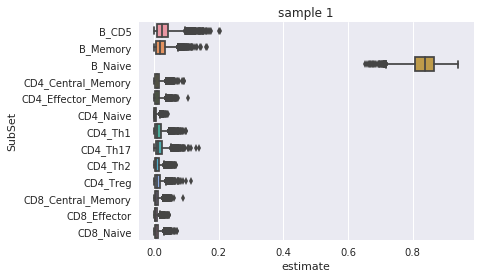

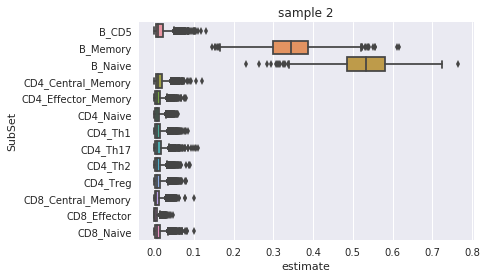

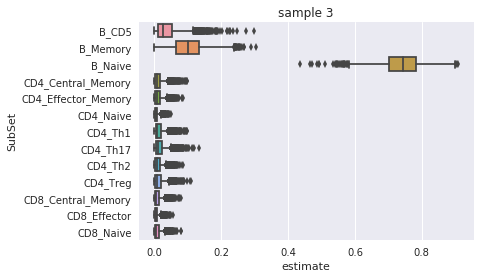

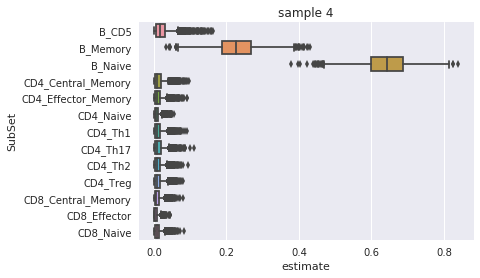

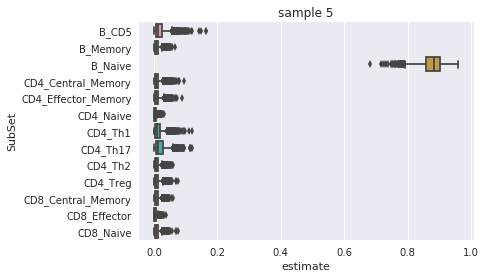

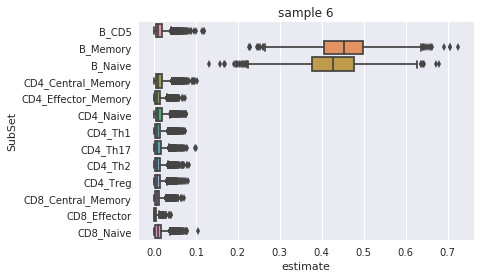

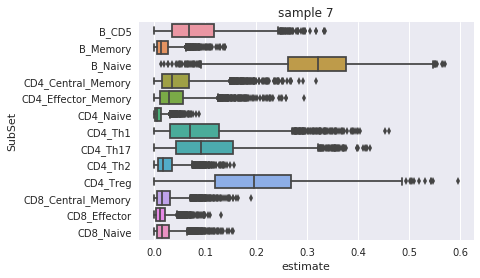

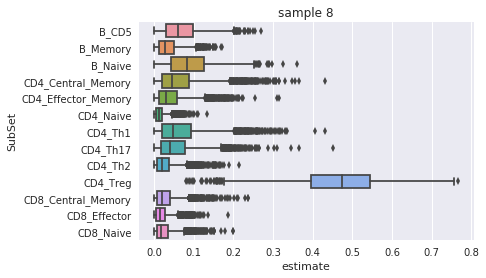

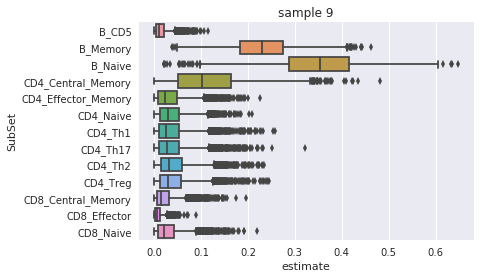

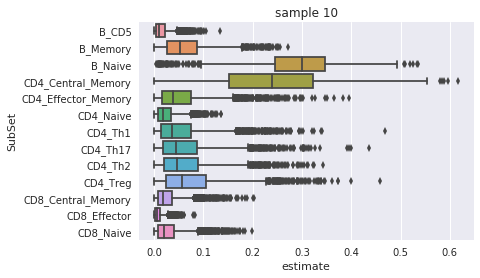

In [73]:
for key, grp in df.groupby('sample_id'):
    plt.figure()
    g = sns.boxplot(data=grp, y='SubSet', x='estimate')
    g.set_title('sample %d' % key)

What is the "true" cell type?

In [74]:
test_data['x2']

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0
0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0
0,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0
0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0


In [75]:
#test_df['SubSet'].unique()

true_cell_type = test_data['x2'].transpose()
#true_cell_type[true_cell_type[0] > 0]
true_cell_type

,0,0,0,0,0,0,0,0,0,0
SubSet[B_CD5],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[B_Memory],0.5,0.5,0.75,0.75,0.25,0.25,0.0,0.00,0.0,0.00
SubSet[B_Naive],0.5,0.5,0.25,0.25,0.75,0.75,0.5,0.25,0.5,0.25
SubSet[CD4_Central_Memory],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Effector_Memory],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Naive],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Th1],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Th17],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Th2],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Treg],0.0,0.0,0.00,0.00,0.00,0.00,0.5,0.75,0.5,0.75


In [76]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

plots/oos-mixtures_model6.2_n500_subset_mixture1.png


/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


plots/oos-mixtures_model6.2_n500_subset_mixture2.png
plots/oos-mixtures_model6.2_n500_subset_mixture3.png
plots/oos-mixtures_model6.2_n500_subset_mixture4.png
plots/oos-mixtures_model6.2_n500_subset_mixture5.png
plots/oos-mixtures_model6.2_n500_subset_mixture6.png
plots/oos-mixtures_model6.2_n500_subset_mixture7.png
plots/oos-mixtures_model6.2_n500_subset_mixture8.png
plots/oos-mixtures_model6.2_n500_subset_mixture9.png
plots/oos-mixtures_model6.2_n500_subset_mixture10.png


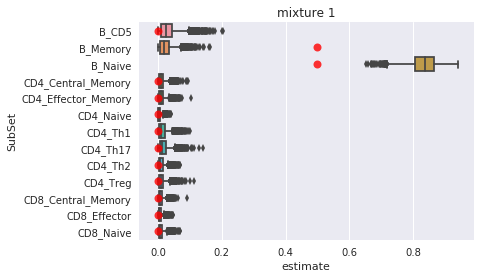

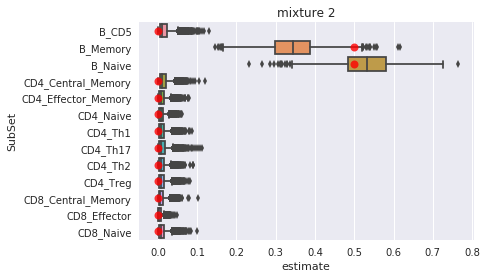

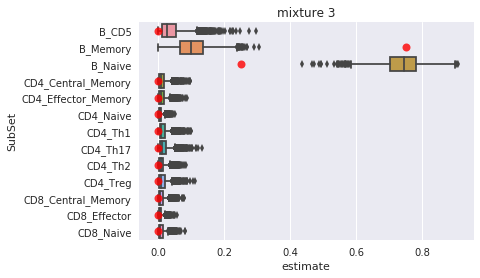

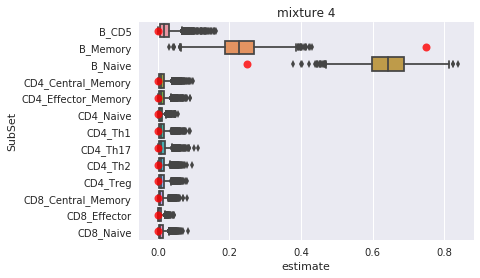

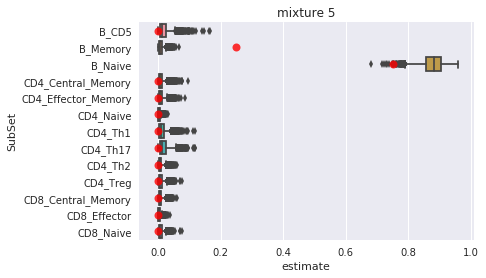

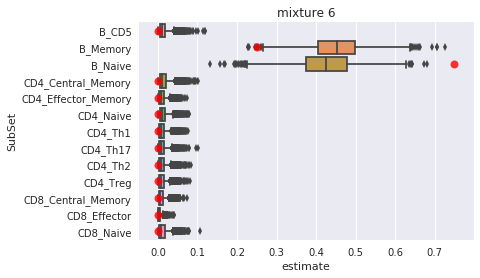

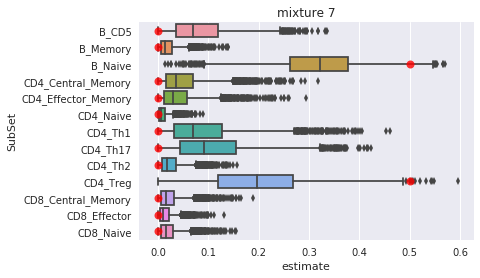

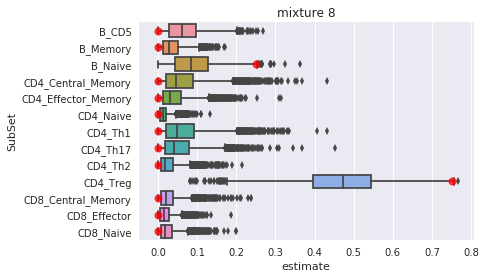

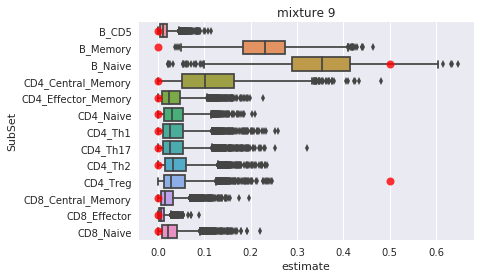

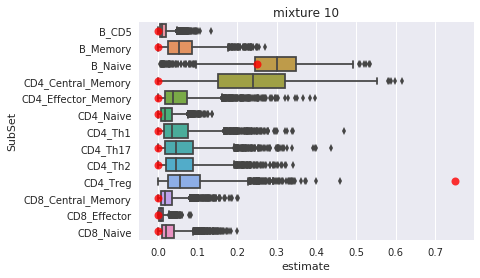

In [78]:
for (key, grp), (_, groundtruth) in zip(df.groupby('sample_id'), test_data['x2'].iterrows()):
    f = plt.figure()
    g = sns.boxplot(data=grp, y='SubSet', x='estimate')
    g.set_title('mixture %d' % key)
    
    # add groundtruth points
    gt = groundtruth.copy()
    gt.index = [s.replace('SubSet[', '').replace(']', '') for s in gt.index]
    gt = pd.DataFrame(gt).reset_index()
    gt.columns = ['SubSet', 'estimate']
    #print(gt)
    sns.stripplot(x="estimate", y="SubSet", data=gt,
                  linewidth=0,
                  #jitter=True,
                  #size=3,
                  #color=".3",
                  size=8,
                  color="r",
                  alpha=.8
                 )
    fname = 'plots/oos-mixtures_model6.2_n500_subset_mixture%d.png' % key
    print(fname)
    savefig(f, fname, dpi=300)
    #break

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


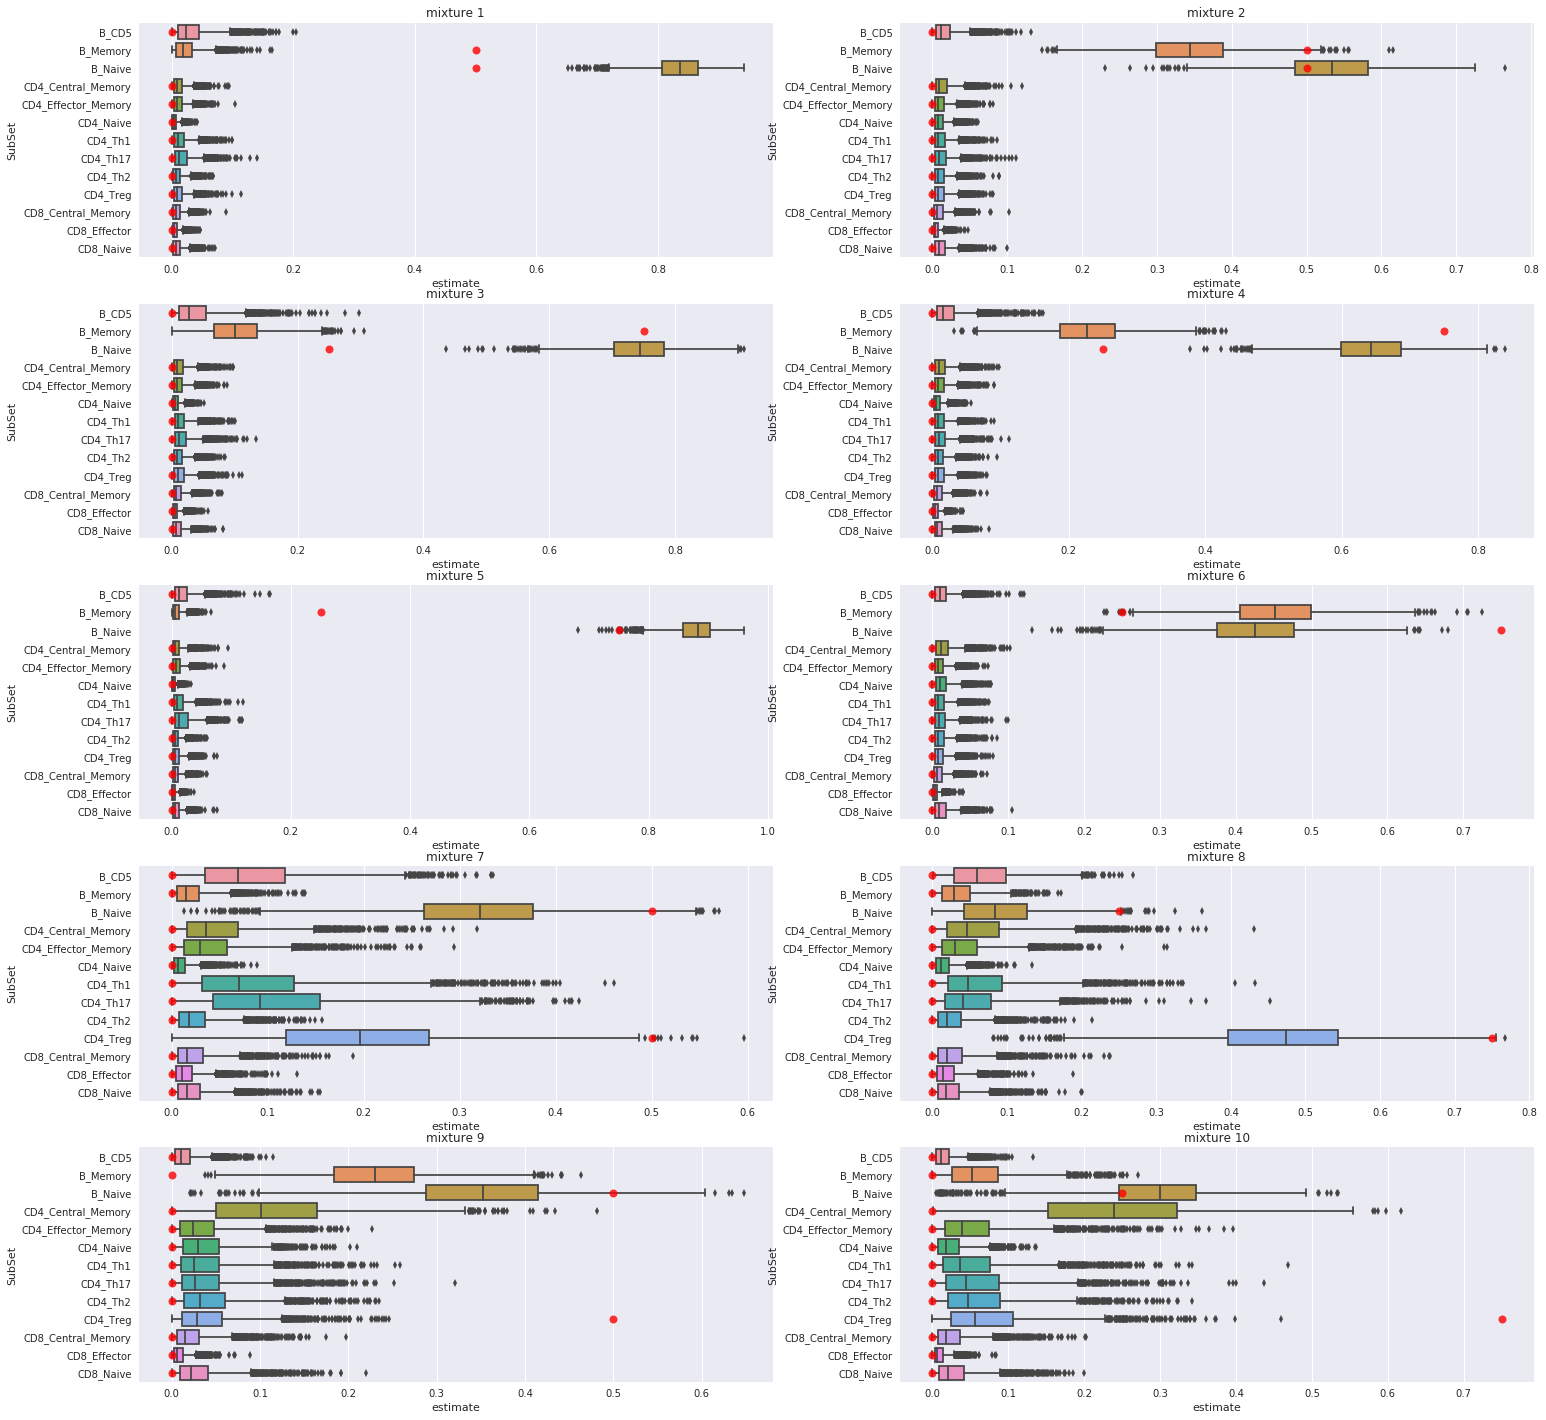

In [79]:
# use subplots
f, ax_arr = plt.subplots(5, 2, figsize=(25,25))

for (key, grp), (_, groundtruth), (axid, ax) in zip(df.groupby('sample_id'),
                                                    test_data['x2'].iterrows(),
                                                    np.ndenumerate(ax_arr)):
    #plt.figure()
    g = sns.boxplot(data=grp, y='SubSet', x='estimate', ax=ax)
    g.set_title('mixture %d' % key)
    
    # add groundtruth points
    gt = groundtruth.copy()
    gt.index = [s.replace('SubSet[', '').replace(']', '') for s in gt.index]
    gt = pd.DataFrame(gt).reset_index()
    gt.columns = ['SubSet', 'estimate']
    #print(gt)
    sns.stripplot(x="estimate", y="SubSet", data=gt,
                  ax=ax,
                  linewidth=0,
                  #jitter=True,
                  #size=3,
                  #color=".3",
                  size=8,
                  color="r",
                  alpha=.8
                 )
    #break
f.show()
savefig(f, 'plots/oos-mixtures_model6.2_n500_subset_ALL.pdf', dpi=300)

## summarize posterior predictions by cell_type

In [ ]:
cell_types = sample_df.drop_duplicates(subset=['cell_type','SubSet']).loc[:,['cell_type','SubSet']]
df2 = pd.merge(cell_types, df, on='SubSet')
df2 = df2.groupby(['cell_type','iter']).agg({'estimate': sum}).reset_index()

In [ ]:
sns.boxplot(data=df2, y='cell_type', x='estimate')